### Installation of packages/libraries
### Εγκατάσταση πακέτων/βιβλιοθηκών

In [ ]:
!pip install swig

In [ ]:
!pip install gymnasium[box2d]

In [ ]:
!pip install ray[rllib]

In [ ]:
!pip install renderlab

### Importing libraries 
### Εισαγωγή βιβλιοθηκών

In [5]:
import gymnasium as gym
import ray
import matplotlib.pyplot as plt
import torch
import os
import renderlab as rl
import imageio
from moviepy.editor import VideoFileClip, concatenate_videoclips
from ray.rllib.algorithms.ppo import PPOConfig, PPO

  if event.key is 'enter':



### Initialization of Ray and creation of a PPO agent using PyTorch for the LunarLander-v3 environment, with configuration of training hyperparameters.

### Αρχικοποίηση του Ray και δημιουργία πράκτορα PPO με χρήση PyTorch για το περιβάλλον LunarLander-v3, με ρύθμιση των υπερπαραμέτρων εκπαίδευσης.

In [6]:
ray.shutdown()
ray.init()

config = PPOConfig()
config.use_critic = True
config.use_gae = True
config.lambda_ = 0.9
config.use_kl_loss = True
config.sgd_minibatch_size = 32
config.num_sgd_iter = 1
config.shuffle_sequences = True
config.vf_loss_coeff = 0.5
config.entropy_coeff = 0.001
config.clip_param = 0.2

# Απενεργοποίηση του νέου API stack
config.api_stack(enable_rl_module_and_learner=False, enable_env_runner_and_connector_v2=False)

config = config.environment("LunarLander-v3")
config = config.framework("torch")

agent = config.build()

2024-12-17 11:45:10,934	INFO worker.py:1821 -- Started a local Ray instance.
2024-12-17 11:45:39,724	INFO trainable.py:161 -- Trainable.setup took 25.687 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2024-12-17 11:45:39,726	WARNING util.py:61 -- Install gputil for GPU system monitoring.


### Execution of 100 training iterations for the agent, recording the average rewards per iteration in a list, and creating a plot to visualize the improvement of rewards during training. 

### Εκτέλεση 100 training iterations για τον πράκτορα, καταγραφή των μέσων ανταμοιβών ανά iteration σε λίστα και δημιουργία διαγράμματος για την απεικόνιση της βελτίωσης των ανταμοιβών κατά τη διάρκεια της εκπαίδευσης.

2024-12-17 11:46:19,507	WARNING deprecation.py:50 -- DeprecationWarning: `ray.rllib.execution.train_ops.multi_gpu_train_one_step` has been deprecated. This will raise an error in the future!


Iteration 1, Average Rewards: -168.24110057896894
Iteration 2, Average Rewards: -155.80553547590623
Iteration 3, Average Rewards: -145.14148865977435
Iteration 4, Average Rewards: -132.14385740331576
Iteration 5, Average Rewards: -120.00289407210876
Iteration 6, Average Rewards: -104.14069442476917
Iteration 7, Average Rewards: -99.24053078218694
Iteration 8, Average Rewards: -103.4033344532294
Iteration 9, Average Rewards: -98.10518520652387
Iteration 10, Average Rewards: -97.37477638246509
Iteration 11, Average Rewards: -91.52454664438582
Iteration 12, Average Rewards: -91.53298823575817
Iteration 13, Average Rewards: -84.73991715068082
Iteration 14, Average Rewards: -77.84908607988157
Iteration 15, Average Rewards: -70.91640142022096
Iteration 16, Average Rewards: -67.28061206616093
Iteration 17, Average Rewards: -63.697055877077
Iteration 18, Average Rewards: -57.00238471419293
Iteration 19, Average Rewards: -52.6781486702093
Iteration 20, Average Rewards: -47.561547693668075
Itera

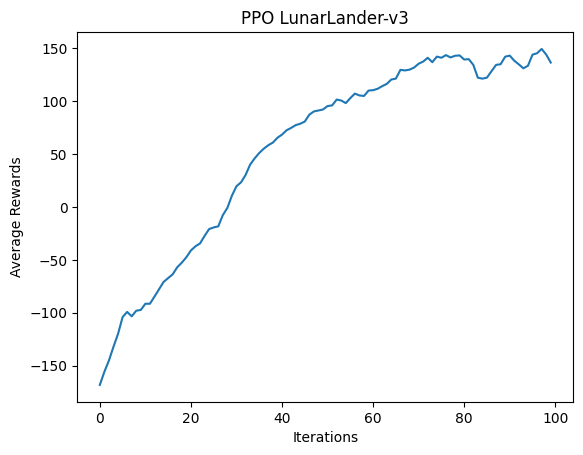

In [7]:
# Αριθμός training iterations
train_iterations = 100

# Λίστα για την αποθήκευση των μέσων ανταμοιβών
average_rewards_per_iteration = []

for i in range(train_iterations):
    result = agent.train()  # Εκτέλεση ενός training iteration
    average_rewards = result["env_runners"]["episode_return_mean"]  # Μέσο reward για αυτό το iteration
    average_rewards_per_iteration.append(average_rewards)

    print(f"Iteration {i + 1}, Average Rewards: {average_rewards}")

# Plot των μέσων ανταμοιβών
plt.plot(average_rewards_per_iteration)
plt.title('PPO LunarLander-v3')
plt.xlabel('Iterations')
plt.ylabel('Average Rewards')
plt.show()

### Saving the agent 
### Αποθήκευση πράκτορα

In [ ]:
# Δημιουργία απόλυτου μονοπατιού
checkpoint_path = os.path.abspath('./ppo_lunarlander_model')

# Αποθήκευση του εκπαιδευμένου πράκτορα
checkpoint_dir = agent.save(checkpoint_path)
print(f"Model saved at: {checkpoint_dir}")

### Testing the agent and saving the top 3 attempts as an MP4 video.
### Δοκιμή του πράκτορα και αποθήκευση των 3 καλύτερων προσπαθειών σε μορφή βίντεο MP4.

In [9]:
# Εκκίνηση του Ray
ray.shutdown()
ray.init()

# Δημιουργία config για τον πράκτορα
config = PPOConfig()
config = config.environment("LunarLander-v3")
config = config.framework("torch")

# Απενεργοποίηση του νέου API stack
config.api_stack(enable_rl_module_and_learner=False, enable_env_runner_and_connector_v2=False)

# Επαναδημιουργία του πράκτορα και φόρτωση του checkpoint
agent = config.build()
checkpoint_path = os.path.abspath('./ppo_lunarlander_model')
agent.restore(checkpoint_path)
print(f"Model loaded from: {checkpoint_path}")

# Ρύθμιση περιβάλλοντος
os.makedirs("./output", exist_ok=True)  # Δημιουργία φακέλου αν δεν υπάρχει
env = gym.make("LunarLander-v3", render_mode="rgb_array")

# Λίστα για αποθήκευση των rewards και των frames
results = []

# Εκτέλεση 10 επεισοδίων
for test_idx in range(10):
    frames = []
    observation, info = env.reset()
    total_reward = 0
    done = False

    while not done:
        action = agent.compute_single_action(observation)  # Επιλογή δράσης
        observation, reward, terminated, truncated, info = env.step(action)  # Εκτέλεση δράσης
        total_reward += reward  # Προσθήκη στο συνολικό reward
        frames.append(env.render())  # Καταγραφή καρέ

        if terminated or truncated:
            done = True

    results.append((total_reward, frames))  # Αποθήκευση reward και καρέ για κάθε δοκιμή
    print(f"Test {test_idx + 1}: Total Reward = {total_reward}")

env.close()

# Ταξινόμηση των αποτελεσμάτων με βάση το reward (φθίνουσα σειρά)
results.sort(key=lambda x: x[0], reverse=True)

# Συνένωση των καρέ από τα 3 καλύτερα επεισόδια
combined_frames = []
for reward, frames in results[:3]:
    combined_frames.extend(frames)  # Συγκέντρωση όλων των καρέ
    print(f"Included episode with Reward = {reward}")

# Αποθήκευση του ενιαίου βίντεο
output_video_path = "./output/lunarlander_best3.mp4"
with imageio.get_writer(output_video_path, fps=30) as video:
    for frame in combined_frames:
        video.append_data(frame)

print(f"Combined video saved successfully at: {output_video_path}")

2024-12-17 12:22:09,318	INFO worker.py:1821 -- Started a local Ray instance.
2024-12-17 12:22:35,789	INFO trainable.py:161 -- Trainable.setup took 23.005 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2024-12-17 12:22:35,792	WARNING util.py:61 -- Install gputil for GPU system monitoring.
2024-12-17 12:22:35,852	INFO trainable.py:583 -- Restored on 172.28.0.12 from checkpoint: Checkpoint(filesystem=local, path=/content/ppo_lunarlander_model)


Model loaded from: /content/ppo_lunarlander_model
Test 1: Total Reward = 287.52815694943513
Test 2: Total Reward = 216.7424508366777
Test 3: Total Reward = 191.16764723195433
Test 4: Total Reward = 81.76747982184797
Test 5: Total Reward = 206.2047240149751
Test 6: Total Reward = 250.54010210455274
Test 7: Total Reward = 275.910370418071
Test 8: Total Reward = 222.6383847283338
Test 9: Total Reward = 219.46094218418818
Test 10: Total Reward = -37.43035310514719
Included episode with Reward = 287.52815694943513
Included episode with Reward = 275.910370418071
Included episode with Reward = 250.54010210455274


Combined video saved successfully at: ./output/lunarlander_best3.mp4


### End!
### Τέλος!